# Harnessing Weather Insights for Accurate Energy Load Forecasting

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import important libraries

In [19]:
# System and environment setup
import platform
import findspark
from pathlib import Path

# PySpark setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# PySpark ML features and models
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Visualization
import matplotlib.pyplot as plt


In [3]:
# Initialize via the full spark path
if platform.system() == 'Windows':
    print("Windows OS detected")
    findspark.init("C:/Spark/spark-3.5.4-bin-hadoop3") # For my local machine
else:
    findspark.init("/usr/local/spark/")

Windows OS detected


In [4]:
# Build the SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Linear Regression Model") \
    .config("spark.executor.memory", "32g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.15.0") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .config("spark.sql.session.timeZone", "UTC") \
    .getOrCreate()

   
# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.      
sc = spark.sparkContext

### Preprocessing I: Read in Weather and Load Data

In [5]:
# Read in the data

# Folder Structure
# data
# |-- geosphere
# |   |-- YYYY
# |      |-- MM.csv
# |      |-- MM.csv
# |
# |-- transparency
# |   |-- YYYY
# |      |-- MM.xml
# |      |-- MM.xml

# Loop through the geosphere folder and read in the data

# Define the base data folder
base_path = Path("./data/geosphere")

# Collect all data frames first to optimize the union operation
dfs = []

for year_folder in base_path.iterdir():
    if year_folder.is_dir():
        for month_file in year_folder.glob("*.csv"):
            print(f"Reading in {month_file}")

            df = spark.read.csv(str(month_file), header=True, inferSchema=True)

            # Convert the time column (string) to a timestamp
            df = df.withColumn("time", to_timestamp(col("time"), "yyyy-MM-dd'T'HH:mmXXX"))
            
            dfs.append(df)
            
            print(f"Read in {df.count()} rows")

if dfs:
    # Combine all DataFrames
    weather = dfs[0]
    for df in dfs[1:]:
        weather = weather.union(df)

    # Aggregate measurements (average from different stations)
    weather = (
        weather.groupBy("time")
        .agg(
            avg("rr").alias("avg_rr"),
            avg("tl").alias("avg_tl"),
            avg("p").alias("avg_p"),
            avg("so_h").alias("avg_so_h"),
            avg("ff").alias("avg_ff"),
        )
        .orderBy("time")
    )

    # Log-transform the measurements (data for rainfall and windspeed is skewed)
    weather = weather.withColumn("log_rr", log1p(col("avg_rr")))
    weather = weather.withColumn("log_ff", log1p(col("avg_ff")))
    
    weather.drop("avg_rr", "avg_ff")
    
    weather.show(10, truncate=False)
    
    print(weather.count())
    weather.printSchema()
else:
    print("No data found")


Reading in data\geosphere\2015\01.csv
Read in 7500 rows
Reading in data\geosphere\2015\02.csv
Read in 8076 rows
Reading in data\geosphere\2015\03.csv
Read in 8940 rows
Reading in data\geosphere\2015\04.csv
Read in 8652 rows
Reading in data\geosphere\2015\05.csv
Read in 8940 rows
Reading in data\geosphere\2015\06.csv
Read in 8652 rows
Reading in data\geosphere\2015\07.csv
Read in 8940 rows
Reading in data\geosphere\2015\08.csv
Read in 8940 rows
Reading in data\geosphere\2015\09.csv
Read in 8652 rows
Reading in data\geosphere\2015\10.csv
Read in 8940 rows
Reading in data\geosphere\2015\11.csv
Read in 8652 rows
Reading in data\geosphere\2015\12.csv
Read in 8940 rows
Reading in data\geosphere\2016\01.csv
Read in 8940 rows
Reading in data\geosphere\2016\02.csv
Read in 8364 rows
Reading in data\geosphere\2016\03.csv
Read in 8940 rows
Reading in data\geosphere\2016\04.csv
Read in 8652 rows
Reading in data\geosphere\2016\05.csv
Read in 8940 rows
Reading in data\geosphere\2016\06.csv
Read in 86

In [6]:
# Loop through the transparency folder and read in the energy data

# Define base path for transparency data
base_path = Path("./data/transparency")

# Collect DataFrames before performing union (optimization)
dfs = []

for year_folder in base_path.iterdir():
    if year_folder.is_dir():
        for month_file in year_folder.glob("*.xml"):
            print(f"Reading transparency data: {month_file}")

            # Read XML data
            df = spark.read.format('xml').option("rowTag", "GL_MarketDocument").load(str(month_file))

            # Extract and explode relevant fields
            df_filtered = df.select(
                col("TimeSeries.Period.timeInterval.start").alias("start_time"),
                col("TimeSeries.Period.timeInterval.end").alias("end_time"),
                col("TimeSeries.Period.resolution").alias("resolution"),
                explode(col("TimeSeries.Period.Point")).alias("Point")  # Flatten Points
            ).select(
                col("start_time"),
                col("end_time"),
                col("resolution"),
                col("Point.position").cast("int").alias("position"),
                col("Point.quantity").cast("double").alias("quantity")
            )

            # Convert ISO 8601 duration (e.g., "PT15M") to minutes dynamically
            df_fixed = df_filtered.withColumn(
                "interval_minutes",
                expr("CAST(SUBSTRING(resolution, 3, LENGTH(resolution) - 3) AS INT)")  # Extracts "15" from "PT15M"
            ).withColumn(
                "actual_time",
                expr("start_time + (position - 1) * interval_minutes * interval 1 minute")
            ).select(
                col("actual_time"),
                col("quantity")
            )
            
            # Aggregate to hourly intervals
            df_hourly = df_fixed.withColumn(
                "hourly_time", date_trunc("hour", col("actual_time"))  # Round down to the hour
            ).groupBy("hourly_time").agg(
                sum("quantity").alias("hourly_quantity")  # Sum all sub-hourly measurements
            )

            # Rename to match the structure of other time series
            df_hourly = df_hourly.select(
                col("hourly_time").alias("timestamp"), col("hourly_quantity").alias("quantity")
            ).orderBy("timestamp")
            
            print(f"Read in {df_hourly.count()} values")
            
            # Append DataFrame to list
            dfs.append(df_hourly)

# Merge all collected DataFrames
if dfs:
    Load = dfs[0]
    for df in dfs[1:]:
        Load = Load.union(df)

    Load.show(10)
    Load.printSchema()
else:
    print("No data found.")



Reading transparency data: data\transparency\2015\01.xml
Read in 624 values
Reading transparency data: data\transparency\2015\02.xml
Read in 672 values
Reading transparency data: data\transparency\2015\03.xml
Read in 744 values
Reading transparency data: data\transparency\2015\04.xml
Read in 720 values
Reading transparency data: data\transparency\2015\05.xml
Read in 744 values
Reading transparency data: data\transparency\2015\06.xml
Read in 720 values
Reading transparency data: data\transparency\2015\07.xml
Read in 744 values
Reading transparency data: data\transparency\2015\08.xml
Read in 744 values
Reading transparency data: data\transparency\2015\09.xml
Read in 720 values
Reading transparency data: data\transparency\2015\10.xml
Read in 744 values
Reading transparency data: data\transparency\2015\11.xml
Read in 720 values
Reading transparency data: data\transparency\2015\12.xml
Read in 744 values
Reading transparency data: data\transparency\2016\01.xml
Read in 744 values
Reading tran

### Preprocessing II: Combine both Data Frames

In [7]:
if Load is not None and weather is not None:    
    # Join the data into a single DataFrame    
    data = Load.join(weather, Load.timestamp == weather.time, "inner").drop("time")
    
    # Rename columns for better understanding
    data = data.withColumnRenamed("timestamp", "time")
    data = data.withColumnRenamed("quantity", "load")

    data = data.withColumnRenamed("log_rr", "rainfall")
    data = data.withColumnRenamed("avg_tl", "temperature")
    data = data.withColumnRenamed("avg_p", "pressure")
    data = data.withColumnRenamed("avg_so_h", "sunshine_duration")
    data = data.withColumnRenamed("log_ff", "wind_speed")
    
    # Add Lag features
    
    # Define window for lagging (ordered by time)
    window_spec = Window().partitionBy().orderBy("time")

    # Add lag features (previous hour's values)
    data = data.withColumn("rainfall_lag_1", lag("rainfall", 1).over(window_spec))
    data = data.withColumn("wind_speed_lag_1", lag("wind_speed", 1).over(window_spec))
    
    # Add lag features (7 previous days values)
    days = []
    for i in range(24, 24*7+1, 24):
        data = data.withColumn(f"load_lag_{i}h_prev_day", lag("load", i).over(window_spec))
        days.append(f"load_lag_{i}h_prev_day")
    
    # Drop rows with missing values
    data = data.dropna()
    
    # Reorder the columns
    data = data.select("time",
                        "load", 
                        "rainfall", 
                        "rainfall_lag_1",
                        "temperature", 
                        "pressure", 
                        "sunshine_duration", 
                        "wind_speed", 
                        "wind_speed_lag_1",
                        *days)
    
    # Print the schema and stats
    data.describe().show()
    data.show(10)
    data.printSchema()
    

+-------+------------------+-------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|summary|              load|           rainfall|    rainfall_lag_1|        temperature|         pressure|  sunshine_duration|         wind_speed|  wind_speed_lag_1|load_lag_24h_prev_day|load_lag_48h_prev_day|load_lag_72h_prev_day|load_lag_96h_prev_day|load_lag_120h_prev_day|load_lag_144h_prev_day|load_lag_168h_prev_day|
+-------+------------------+-------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|  count|             87384|      

### Machine Learning

In [9]:
# Keep original timestamp before converting to Unix seconds
unix_time_data = data.withColumn("unix_time", unix_timestamp("time"))  # Store Unix time separately

# Extract day of the year (1-365/366) from the original timestamp column
unix_time_data = unix_time_data.withColumn("day_of_year", dayofyear(col("time")))

# Extract time of day in seconds (seconds since midnight)
unix_time_data = unix_time_data.withColumn(
    "time_of_day", expr("hour(time) * 3600 + minute(time) * 60 + second(time)")
)

# Normalize day of the year to range (0, 2π) for periodic encoding
ml_data = unix_time_data.withColumn("day_cos", cos(2 * 3.1416 * col("day_of_year") / 365))

# Normalize time of day
ml_data = ml_data.withColumn("time_cos", cos(2 * 3.1416 * col("time_of_day") / 86400))

# Define new feature columns
#feature_columns = ["day_cos", "time_cos", "is_weekend", "rainfall", "temperature", "pressure", "sunshine_duration", "wind_speed"]

feature_columns = [     "day_cos",
                        "time_cos",
                        "rainfall", 
                        "rainfall_lag_1",
                        "temperature", 
                        "pressure", 
                        "sunshine_duration", 
                        "wind_speed", 
                        "wind_speed_lag_1", 
                        *days
                        ]


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


# Transform data
df_ml = assembler.transform(ml_data).select("load", "features")

df_ml.cache()

# Show transformed data
df_ml.show(5, truncate=False)



+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|load   |features                                                                                                                                                                               |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26782.0|[0.9750644161242169,1.0,0.0,0.0,0.875,977.0727272727272,0.0,1.0355541527009728,0.9229352745928237,25661.0,20349.0,22633.0,26239.0,25428.0,22272.0,20881.0]                             |
|26012.0|[0.9750644161242169,0.9659256678396477,0.0,0.0,0.6583333333333333,977.1,0.0,0.9458495341156996,1.0355541527009728,24350.0,19702.0,19743.0,25872.0,25441.0,22567.0,20059.0]             |
|24886.0|[0.9750644161242169,0

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_df = scaler.fit(df_ml).transform(df_ml).select("load", "features_scaled")
scaled_df = scaled_df.withColumnRenamed("features_scaled", "features")
scaled_df.cache()

scaled_df.show(5, truncate=False)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|load   |features                                                                                                                                                                                                                                                        |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26782.0|[1.3805833005535293,1.4142038548466405,0.0,0.0,0.10425313198102151,127.20425648104329,0.0,3.728229236439942,3.322787087349065,4.705963608502149,3.731412880626217,4.149826023925306,4.81096384

In [11]:
# Randomly splits this :class:`DataFrame` with the provided weights.
train_data, test_data = scaled_df.randomSplit([.8,.2],seed=1234)

train_data.take(5)

[Row(load=2653.0, features=DenseVector([1.2065, 0.0, 0.4017, 1.0893, 0.5898, 126.8326, 0.0, 4.8534, 4.6283, 5.649, 6.7009, 6.8229, 6.8007, 6.5825, 6.6605, 5.4812])),
 Row(load=3793.0, features=DenseVector([1.2065, 1.2247, 0.0461, 0.0461, 0.7437, 126.7285, 0.0, 4.8456, 4.7426, 4.8974, 5.4571, 5.6695, 5.5992, 5.5033, 5.418, 4.7931])),
 Row(load=3841.0, features=DenseVector([1.2065, 0.7071, 0.1371, 0.3149, 0.5928, 126.8042, 0.0, 4.6117, 4.7506, 5.0797, 5.8855, 6.1366, 6.0513, 5.577, 5.8085, 5.0276])),
 Row(load=4467.0, features=DenseVector([1.2065, -1.366, 0.5294, 0.6129, 0.6593, 126.7344, 0.0774, 4.197, 4.6859, 5.5694, 6.6311, 6.8998, 6.7992, 6.3285, 6.6768, 4.9528])),
 Row(load=4573.0, features=DenseVector([1.2065, 0.366, 0.3149, 0.4017, 0.5987, 126.822, 0.0, 4.7506, 4.8534, 5.3599, 6.2671, 6.5176, 6.522, 6.0185, 6.2382, 5.2843]))]

In [12]:
# Linear regression.
# The learning objective is to minimize the specified loss function, with regularization.
#More about regParam and elasticNetParam (seen as penalties on the loss function that minimises error in predicitons) can be found here: https://runawayhorse001.github.io/LearningApacheSpark/reg.html
# The maxIter parameter sets an upper limit on the number of iterations the optimization algorithm can perform regarding the loss function
# By default the LinearRegression function expects another column named "features"

lr = LinearRegression(labelCol="load", maxIter=500)

# Fits a model to the input dataset with optional parameters.
linearModel = lr.fit(train_data)

# Get the summary of the model
trainingSummary = linearModel.summary

# Print the Score of the model
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 2080.610564
r2: 0.854615


In [14]:
# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="load", maxIter=500)

# Train the Linear Regression model
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

print(10 * "-")
print("LinearRegression")
print(f"RMSE: {lr_rmse}")
print(f"r2: {lr_model.summary.r2}")
print(10 * "-")

+------+------------------+
|  load|        prediction|
+------+------------------+
|3347.0|31746.346907770516|
|4066.0| 32040.79596120381|
|6507.0|23169.432384981388|
|6683.0|23661.043106239806|
|7137.0|33900.320100024415|
+------+------------------+
only showing top 5 rows

----------
LinearRegression
RMSE: 2081.5735390243553
r2: 0.8546148727534763
----------


In [ ]:
# Define the Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="load", numTrees=100, maxDepth=10, seed=4343)

# Train the Random Forest model
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate performance
evaluator_rmse = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator_rmse.evaluate(rf_predictions)

evaluator_r2 = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="r2")
rf_r2 = evaluator_r2.evaluate(rf_predictions)
    
print(10 * "-")
print("RandomForestRegressor")
print(f"RMSE: {rf_rmse}")
print(f"r2: {rf_r2}")
print(10 * "-")

+-------+------------------+
|load   |prediction        |
+-------+------------------+
|3347.0 |29388.449581765723|
|4066.0 |29634.887573576   |
|6507.0 |20143.740159180834|
|6683.0 |18774.657505632225|
|7137.0 |15377.244292211479|
|7361.0 |19693.94994725842 |
|7366.0 |15777.411911415842|
|8186.0 |16078.072748586279|
|11143.0|23796.250442528642|
|11429.0|24560.5822091864  |
+-------+------------------+
only showing top 10 rows

----------
RandomForestRegressor
RMSE: 1524.561821671188
R²: 0.9213859540008189
----------


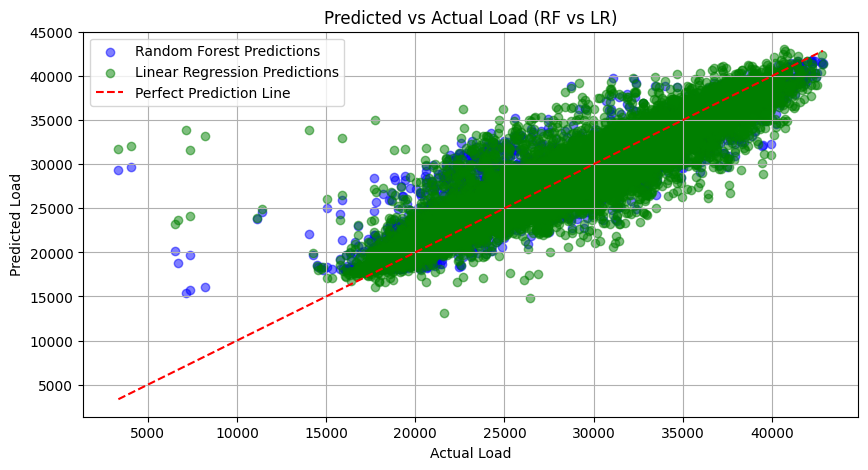

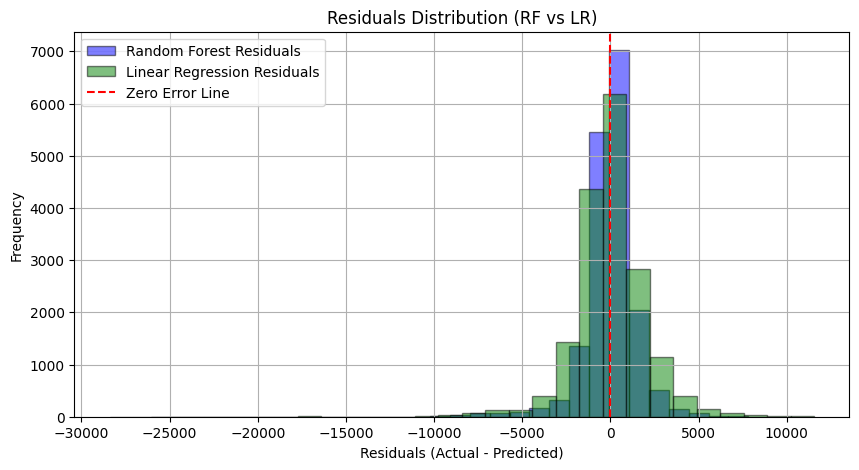

In [20]:
import matplotlib.pyplot as plt

# Convert Spark DataFrames to Pandas
rf_predictions_pd = rf_predictions.select("load", "prediction").toPandas()
lr_predictions_pd = lr_predictions.select("load", "prediction").toPandas()

# Scatter plot of actual vs predicted values for both models
plt.figure(figsize=(10, 5))
plt.scatter(rf_predictions_pd["load"], rf_predictions_pd["prediction"], alpha=0.5, label="Random Forest Predictions", color='blue')
plt.scatter(lr_predictions_pd["load"], lr_predictions_pd["prediction"], alpha=0.5, label="Linear Regression Predictions", color='green')
plt.plot(
    [rf_predictions_pd["load"].min(), rf_predictions_pd["load"].max()],
    [rf_predictions_pd["load"].min(), rf_predictions_pd["load"].max()],
    color="red",
    linestyle="--",
    label="Perfect Prediction Line"
)
plt.xlabel("Actual Load")
plt.ylabel("Predicted Load")
plt.title("Predicted vs Actual Load (RF vs LR)")
plt.legend()
plt.grid(True)
plt.show()

# Residuals histogram for both models
rf_residuals = rf_predictions_pd["load"] - rf_predictions_pd["prediction"]
lr_residuals = lr_predictions_pd["load"] - lr_predictions_pd["prediction"]

plt.figure(figsize=(10, 5))
plt.hist(rf_residuals, bins=30, alpha=0.5, label="Random Forest Residuals", color='blue', edgecolor='k')
plt.hist(lr_residuals, bins=30, alpha=0.5, label="Linear Regression Residuals", color='green', edgecolor='k')
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution (RF vs LR)")
plt.legend()
plt.grid(True)
plt.show()
